In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

from scipy.io import loadmat
plt.rcParams["figure.autolayout"] = True
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2
plt.rcParams.update({'font.size': 15})

In [2]:
def compute_phase(freq, values):
    return 2*np.pi*values*freq*180/np.pi

In [3]:
def pre_process_simulation(df, columns, signals, new_columns):
    df = df[columns]
    for i, column in enumerate(new_columns):
        df[column] = df[signals[i]]
    for signal in new_columns:
        df[f'mag_{signal}'] = df[signal].apply(lambda x: float(x[1:-1].split(',')[0][:-2]))
        df[f'phase_{signal}'] = df[signal].apply(lambda x: float(x[1:-1].split(',')[1][:-1]))
    df = df.drop(new_columns, axis=1)
    df = df.drop(signals, axis=1)
    df['phase_complete_filter'][:107] = -df['phase_complete_filter'][:107]
    df['phase_complete_filter'][-99:] = -df['phase_complete_filter'][-99:]
    return df

In [4]:
measure = pd.read_csv('bode_filtro.csv', decimal=',')

In [5]:
measure['log_mag'] = 20*np.log10(measure['mag'].values)

In [6]:
simulation = pd.read_csv('complete_active_bandpass.txt', sep='\t')
simulation.columns

Index(['Freq.', 'V(n007)/V(n010)', 'V(n002)/V(n010)', 'V(n004)/V(n002)',
       'V(n004)/V(n010)', 'V(n004)', 'V(p002)'],
      dtype='object')

In [7]:
simulation_df = pre_process_simulation(simulation, 
                                       ['Freq.', 'V(n007)/V(n010)', 
                                        'V(n002)/V(n010)', 'V(n004)/V(n002)',
                                        'V(n004)/V(n010)'],
                                       ['V(n007)/V(n010)', 'V(n002)/V(n010)', 
                                        'V(n004)/V(n002)','V(n004)/V(n010)'],
                                       ['buffer', 'first_stage', 'second_stage',
                                        'complete_filter'])

/tmp/ipykernel_53179/2401459848.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column] = df[signals[i]]


In [8]:
simulation_df

,Freq.,mag_buffer,phase_buffer,mag_first_stage,phase_first_stage,mag_second_stage,phase_second_stage,mag_complete_filter,phase_complete_filter
0,1000.000000,-0.000259,-0.017054,-41.829694,-73.683346,-43.257256,-71.745204,-85.086950,145.428550
1,1023.292992,-0.000259,-0.017452,-41.613820,-74.041819,-43.037697,-72.138480,-84.651517,146.180299
2,1047.128548,-0.000259,-0.017860,-41.398593,-74.393520,-42.818925,-72.524597,-84.217519,146.918117
3,1071.519305,-0.000259,-0.018278,-41.183988,-74.738534,-42.600912,-72.903621,-83.784901,147.642155
4,1096.478196,-0.000259,-0.018705,-40.969981,-75.076946,-42.383629,-73.275624,-83.353610,148.352570
...,...,...,...,...,...,...,...,...,...
296,912010.839356,0.006490,-15.804688,-30.449852,51.870042,-29.955791,65.799474,-60.405642,-117.669516
297,933254.300797,0.006490,-16.182797,-30.591653,51.014592,-30.101033,65.290661,-60.692685,-116.305254
298,954992.586021,0.006460,-16.570403,-30.731282,50.142123,-30.244187,64.774272,-60.975469,-114.916395
299,977237.220956,0.006395,-16.967775,-30.868696,49.252335,-30.385208,64.250309,-61.253904,-113.502644


In [9]:
dict_theory = loadmat('bode.mat')
theory_df = pd.DataFrame()
prefixes = ['1', '2', 'T']
for prefix in prefixes:
    size_array = dict_theory[f'mag{prefix}'].shape[2]
    dict_theory[f'mag{prefix}'] = 20*np.log10(dict_theory[f'mag{prefix}'].reshape((size_array)))
    dict_theory[f'phase{prefix}'] = dict_theory[f'phase{prefix}'].reshape((size_array))
    dict_theory[f'wout{prefix}'] = dict_theory[f'wout{prefix}']/(2*np.pi)

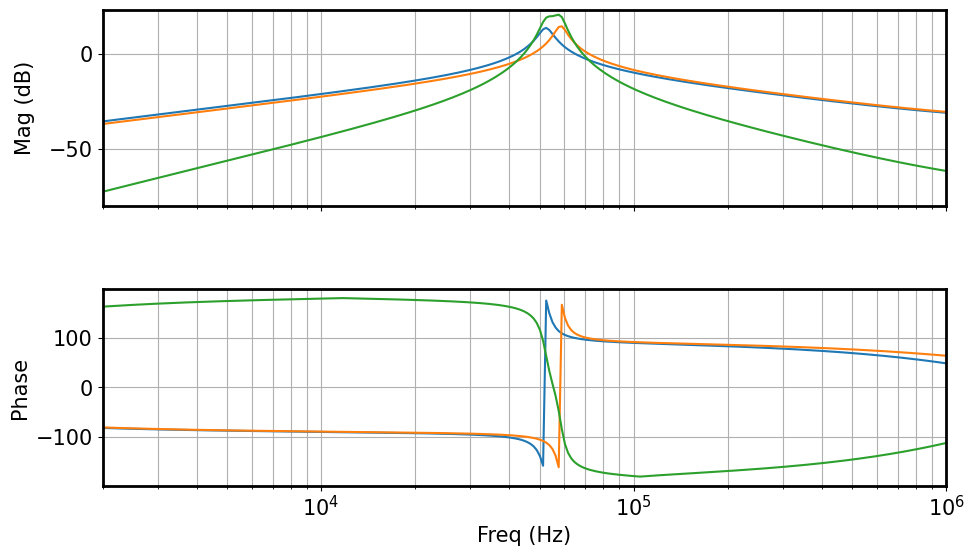

In [10]:
plt.figure(figsize=(10, 8))
plt.clf()
gs1 = gridspec.GridSpec(4, 4)
gs1.update(wspace=0.15, hspace=0.05)
ax1 = plt.subplot(311)
#ax1.set_ylim([-0.08, 0.08])
ax1.set_ylabel(r'Mag (dB)')
ax1.yaxis.labelpad = 10
ax1.set_xscale('log')
ax1.plot(simulation_df['Freq.'].values, simulation_df['mag_first_stage'].values)
ax1.plot(simulation_df['Freq.'].values, simulation_df['mag_second_stage'].values)
ax1.plot(simulation_df['Freq.'].values, simulation_df['mag_complete_filter'].values)
#plt.vlines(60000, -80, 23, linestyle='dashed', color='gray', alpha=0.9)
#plt.vlines(70000, -80, 23, linestyle='dashed', color='gray', alpha=0.9)
ax1.set_ylim([-80, 23])
plt.tick_params('x', labelbottom=False)
plt.grid(True, which="both", ls="-")
measure = measure.dropna()
measure['phase'] = 2*np.pi*measure['delta_t']*measure['freq']*180/np.pi
ax2 = plt.subplot(312, sharex=ax1)
#ax2.set_ylim([-0.08,0.08])
ax2.set_ylabel(r'Phase')
ax2.set_xscale('log')
ax2.set_xlabel('Freq (Hz)')
ax2.plot(simulation_df['Freq.'].values, simulation_df['phase_first_stage'].values)
ax2.plot(simulation_df['Freq.'].values, simulation_df['phase_second_stage'].values)
ax2.plot(simulation_df['Freq.'].values, simulation_df['phase_complete_filter'].values)
ax2.set_xlim([2000, 1e6])
#plt.tick_params('x', labelbottom=False)
#plt.ticklabel_format(style='sci')
#plt.rcParams.update({'font.size': 10})
plt.grid(True, which="both", ls="-")
#ax2.legend(['Theory', 'Simulation', 'Experiment'])
#plt.xlim(0.01, 10.0)
plt.show()

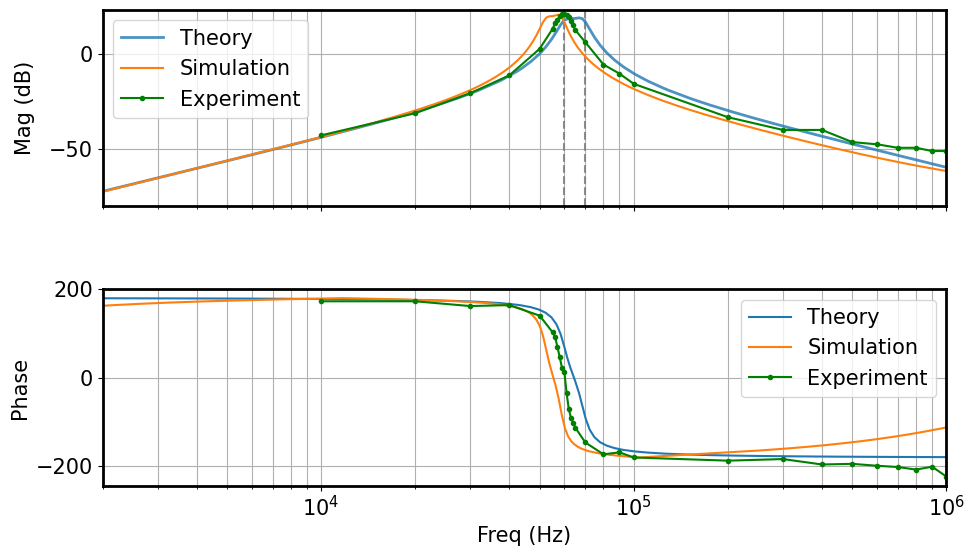

In [11]:
plt.figure(figsize=(10, 8))
ax1 = plt.subplot(311)
#ax1.set_ylim([-0.08, 0.08])
ax1.set_ylabel(r'Mag (dB)')
ax1.yaxis.labelpad = 10
ax1.set_xscale('log')
plt.plot(dict_theory['woutT'], dict_theory['magT'], linewidth=2, alpha=0.8)
plt.plot(simulation_df['Freq.'].values, simulation_df['mag_complete_filter'].values)
plt.plot(measure['freq'].values, measure['log_mag'].values, marker='.', color='g')
plt.vlines(60000, -80, 23, linestyle='dashed', color='gray', alpha=0.9)
plt.vlines(70000, -80, 23, linestyle='dashed', color='gray', alpha=0.9)
ax1.set_ylim([-80, 23])
ax1.legend(['Theory', 'Simulation', 'Experiment'])


plt.tick_params('x', labelbottom=False)
plt.grid(True, which="both", ls="-")
measure = measure.dropna()
measure['phase'] = 2*np.pi*measure['delta_t']*measure['freq']*180/np.pi
ax2 = plt.subplot(312, sharex=ax1)
#ax2.set_ylim([-0.08,0.08])
ax2.set_ylabel(r'Phase')
ax2.set_xscale('log')
ax2.set_xlabel('Freq (Hz)')
plt.plot(dict_theory['woutT'], dict_theory['phaseT'])
plt.plot(simulation_df['Freq.'].values, simulation_df['phase_complete_filter'].values)
plt.plot(measure['freq'].values, measure['phase'].values, marker='.', color='g')
ax2.set_xlim([2000, 1e6])
#plt.tick_params('x', labelbottom=False)
#plt.ticklabel_format(style='sci')
plt.grid(True, which="both", ls="-")
ax2.legend(['Theory', 'Simulation', 'Experiment'])
#plt.xlim(0.01, 10.0)
plt.show()

#plt.figure(figsize=(10, 5))
#plt.plot(simulation_df['Freq.'].values, simulation_df['phase_complete_filter'].values)
#plt.scatter(measure['freq'].values, measure['phase'].values, marker='.', color='g')
#plt.xscale('log')
#.xlim([1000, 1e6])
#plt.ylim([-200, 200])
#plt.xlabel('Freq (Hz)')
#plt.ylabel('Phase (Degrees)')
#plt.grid()
#plt.legend(['Theory', 'Simulation', 'Experiment'])
#plt.plot([60e3,60e3], [-65, 30])
#plt.show()

In [12]:
filt_measure = measure[(measure['freq']>55000)&(measure['freq']<65000)]
filt_measure.head(9)

,freq,mag,delta_t,log_mag,phase
10,56000,6.2,4.600000e-06,15.847834,92.736
11,57000,7.8,3.400000e-06,17.841892,69.768
12,58000,9.6,2.200000e-06,19.645425,45.936
13,59000,11.0,1.000000e-06,20.827854,21.240
14,60000,11.2,6.000000e-07,20.984360,12.960
15,61000,10.6,-1.600000e-06,20.506117,-35.136
16,62000,9.0,-3.200000e-06,19.084850,-71.424
17,63000,7.2,-4.000000e-06,17.146650,-90.720
18,64000,5.5,-4.400000e-06,14.807254,-101.376


In [13]:
np.pi*(filt_measure['phase'].values[0] - filt_measure['phase'].values[-1])/(180*filt_measure['freq'].values[0] - filt_measure['freq'].values[-1])

6.0884667848804106e-05

In [14]:
import os
os.listdir('./data')

['.DS_Store',
 'Sem NP - Com filtro',
 '12mbar - Com Filtro',
 'Sem NP - Sem Filtro',
 'com-filtro',
 '16hpa-NP-semfiltro',
 '12mbar - Sem Filtro']

In [15]:
folders = ['12mbar - Sem Filtro',
 'Sem NP - Sem Filtro',
 'Sem NP - Com Filtro',
 '12mbar - Com Filtro']

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(df['freq'].values, df['phase'].values)
plt.xscale('log')
plt.xlim([10000, 1e6])
plt.grid()
plt.xlabel('Freq (Hz)')
plt.plot([60e3,60e3], [-200, 200])
plt.ylim([-200,200])
plt.ylabel('Phase (Degrees)')
plt.show()

NameError: name 'df' is not defined

<Figure size 1000x500 with 0 Axes>